In [1]:
from tensortrade.data.cdd import CryptoDataDownload

import pandas as pd
import numpy as np

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp form "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [2]:
import ta

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def sharpe(returns: np.array, risk_free_rate: float = 0) -> float:
    return (returns.mean() - risk_free_rate) / returns.std()

def maximum_drawdown(net_worth: np.array) -> float:
    n = len(net_worth)
    nav = net_worth.copy()
    mdd = 0
    peak = -np.inf
    for i in range(n):
        if nav[i] > peak:
            peak = nav[i]
        dd = 100*(peak - nav[i]) / peak
        if dd > mdd:
            mdd = dd
    return mdd

def fracdiff(s: 'pd.Series[pd.Float64Dtype]', d: float = 0.6, window: int = 25) -> 'pd.Series[pd.Float64Dtype]':
    c = np.tile([1.0, -1.0], -(-window // 2))[:window]
    w = c*binom(d, np.arange(window))
    w = w[::-1]
    frac = s.rolling(window=window, min_periods=window).agg(lambda v: np.dot(w.T, v))
    return frac

def generate_features(data):
    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'date': 'Date', 
                                'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('Date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'dfast': data['Close'].rolling(window=10).std().abs(),
        'dmedium': data['Close'].rolling(window=50).std().abs(),
        'dslow': data['Close'].rolling(window=100).std().abs(),
        'fast': data['Close'].rolling(window=10).mean(),
        'medium': data['Close'].rolling(window=50).mean(),
        'slow': data['Close'].rolling(window=100).mean(),
        'ema_fast': ta.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_medium': ta.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_slow': ta.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'lr': np.log(data['Close']).diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Generate all default indicators from ta library
    df = ta.add_all_ta_features(data, 'Open', 'High', 'Low', 'Close', 'Volume', fillna=True)

    # Concatenate both manually and automatically generated features
    data = pd.concat([df, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Date': 'date', 
                                'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    return data

In [3]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [4]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.800000,8793.0,8714.900000,8739.0,8988053
1,2018-05-15 07:00 AM,8739.000000,8754.8,8719.300000,8743.0,2288904
2,2018-05-15 08:00 AM,8743.000000,8743.1,8653.200000,8723.7,8891773
3,2018-05-15 09:00 AM,8723.700000,8737.8,8701.200000,8708.1,2054868
4,2018-05-15 10:00 AM,8708.100000,8855.7,8695.800000,8784.4,17309722
...,...,...,...,...,...,...
32433,2022-01-25 08:00 PM,37101.030041,37135.0,36653.000000,36897.0,9529030
32434,2022-01-25 09:00 PM,36900.000000,36945.0,36461.000000,36595.0,15021792
32435,2022-01-25 10:00 PM,36597.000000,36835.0,36486.000000,36835.0,9658911
32436,2022-01-25 11:00 PM,36835.000000,37070.0,36754.000000,36986.0,4049707


In [5]:
dataset = generate_features(data)
dataset

/usr/local/lib/python3.6/dist-packages/ta/trend.py:769: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:774: RuntimeWarning:

invalid value encountered in double_scalars



,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,slow,ema_fast,ema_medium,ema_slow,lr,rsi_5,rsi_10,rsi_100,macd_short,macd_long
0,7897.300000,7898.8,7849.800000,7877.4,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,-1.586737e+04,...,8269.03880,7879.763903,7890.436477,8137.070233,-0.002523,54.694594,62.862413,58.177953,10.871904,31.873058
1,7877.400000,7889.7,7661.000000,7700.0,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,-9.556783e+04,...,8262.21880,7819.842602,7855.811663,8123.621918,-0.022778,83.970505,78.146122,60.860099,-5.426751,34.355233
2,7700.000000,7700.1,7548.100000,7605.4,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,-5.454997e+04,...,8254.82080,7748.361735,7810.282270,8107.676628,-0.012362,88.796304,82.430355,62.167022,-21.497215,37.504922
3,7605.400000,7623.6,7441.800000,7511.1,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,-4.292364e+04,...,8246.92580,7669.274490,7755.885493,8089.320424,-0.012477,91.852619,85.564709,63.397644,-36.146245,41.269618
4,7511.100000,7551.6,7403.000000,7489.1,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,-3.572163e+04,...,8238.78980,7609.216327,7707.379040,8070.852104,-0.002933,92.453006,86.202747,63.676078,-41.976877,44.917996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32233,37101.030041,37135.0,36653.000000,36897.0,9529030,1.015426e+10,-4440425588,-0.044424,1.518061e+09,-1.575477e+06,...,35750.63159,36996.499922,36839.411214,36178.299460,-0.005783,48.483315,42.133757,52.180247,49.637765,-184.980100
32234,36900.000000,36945.0,36461.000000,36595.0,15021792,1.014755e+10,-4455447380,-0.076612,6.531117e+08,-6.153993e+05,...,35732.79159,36862.666615,36794.972811,36191.121015,-0.008219,62.034701,49.562954,52.723389,-8.399734,-191.776968
32235,36597.000000,36835.0,36486.000000,36835.0,9658911,1.015721e+10,-4445788469,-0.057153,8.909727e+08,-1.535629e+05,...,35718.09159,36853.444410,36802.250482,36210.932676,0.006537,49.182894,44.516364,52.247027,-18.423196,-200.438385
32236,36835.000000,37070.0,36754.000000,36986.0,4049707,1.015911e+10,-4441738762,-0.056832,8.510489e+08,1.962463e+06,...,35707.99159,36897.629606,36835.659485,36234.780901,0.004091,42.292165,41.558209,51.948737,-10.939185,-209.982639


In [6]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

In [7]:
# Things to understand here:
# Writing a Renderer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        price = list(history.close)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = price[i]
                else:
                    sell[i] = price[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(price)), price, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [8]:
# Things to understand here:
# execution_order
# Types of execution logic
# Exchange
# DataFeed
# renderer_feed
# default (env)

import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.env.default.rewards import PBR, RiskAdjustedReturns, SimpleProfit
from tensortrade.env.default.actions import BSH, ManagedRiskOrders
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio


def create_env(config):
    data = pd.read_csv(filepath_or_buffer=config["csv_filename"], 
                       parse_dates=['date']).fillna(method='backfill').fillna(method='ffill')

    commission = 0.1  # TODO: adjust according to your commission percentage, if present
    price = Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")
    bitstamp_options = ExchangeOptions(commission=commission)
    bitstamp = Exchange("bitstamp", service=execute_order, options=bitstamp_options)(price)

    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0 * BTC)

    portfolio = Portfolio(USD, [cash, asset])

    features = []
    for c in data.columns[1:]:
        s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
        features += [s]

    cp = Stream.select(features, lambda s: s.name == "close")

    feed = DataFeed(features)
    feed.compile()

    reward_scheme = PBR(price=price)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(list(data["date"])).rename("date"),
        Stream.source(list(data["open"]), dtype="float").rename("open"),
        Stream.source(list(data["high"]), dtype="float").rename("high"),
        Stream.source(list(data["low"]), dtype="float").rename("low"),
        Stream.source(list(data["close"]), dtype="float").rename("close"), 
        Stream.source(list(data["volume"]), dtype="float").rename("volume"), 
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

ray.init(include_dashboard=True, ignore_reinit_error=True)

register_env("TradingEnv", create_env)

2022-01-27 00:36:47,551	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-01-27 00:36:47,556	WARNING services.py:1826 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.98gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


In [9]:
# Setting this flag to true will wrap the model in an LSTM
use_lstm = True

# Determine the size of the LSTM cell which will correspond to the size of the hidden state output of the LSTM
lstm_cell_size = 512

In [10]:
# Specific configuration keys that will be used during training
env_config_training = {
    "window_size": 14,  # We want to look at the last 14 samples (hours)
    "reward_window_size": 7,  # And calculate reward based on the actions taken in the next 7 hours
    "max_allowed_loss": 0.10,  # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "csv_filename": train_csv  # The variable that will be used to differentiate training and validation datasets
}
# Specific configuration keys that will be used during evaluation (only the overridden ones)
env_config_evaluation = {
    "max_allowed_loss": 1.00,  # During validation runs we want to see how bad it would go. Even up to 100% loss.
    "csv_filename": test_csv,  # The variable that will be used to differentiate training and validation datasets
}


analysis = tune.run(
    "PPO",
    stop={
        "episode_reward_mean": 500,
        "training_iteration": 20,
    },
    config={
        "env": "TradingEnv",
        "env_config": env_config_training,
        "log_level": "ERROR",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 0.005,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "model": {
            "use_lstm": use_lstm,
            "lstm_cell_size": lstm_cell_size
        },
        "gamma": 0.99,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01,
        "evaluation_config": {
            "env_config": env_config_evaluation,  # The dictionary we built before (only the overriding keys to use in evaluation)
            "explore": False,  # We don't want to explore during evaluation. All actions have to be repeatable.
        },
    },
    checkpoint_at_end=True
)

Trial name,status,loc
PPO_TradingEnv_36bfe_00000,PENDING,


2022-01-27 00:36:51,126	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
(PPO pid=5590) 2022-01-27 00:36:55,871	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=5590) 2022-01-27 00:36:55,871	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=5588) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=5588) 
(RolloutWorker pid=5588) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=5588) 
(RolloutWorker pid=5594) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=5594) 
(RolloutWorker pid=5594) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=5594) 
(PPO pid=5590) /usr/local/lib/python3.6/dist-packages/gym/logger.

Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


(PPO pid=5590) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(PPO pid=5590) 
(PPO pid=5590) Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
(PPO pid=5590) 
(PPO pid=5590) 2022-01-27 00:37:03,074	WARNING util.py:57 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=5588) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(RolloutWorker pid=5588) 
(RolloutWorker pid=5588) Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
(RolloutWorker pid=5588) 
(RolloutWorker pid=5594) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(RolloutWorker pid=5594) 
(RolloutWorker pid=5594) Conversion of the second argument of issubdtype from `int` to `np.signedinteger

Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Trial name,status,loc
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590


Result for PPO_TradingEnv_36bfe_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_00-39-59
  done: false
  episode_len_mean: 18.47906976744186
  episode_media: {}
  episode_reward_max: 859.100000000004
  episode_reward_mean: 27.48604651162832
  episode_reward_min: -809.6999999999971
  episodes_this_iter: 215
  episodes_total: 215
  experiment_id: 24a371e8dfc342d4a5944195365b4acd
  hostname: 1560ecedb02e
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.20000000000000004
          cur_lr: 0.10000000000000002
          entropy: 0.6399631786250299
          entropy_coeff: 0.01
          kl: 0.0623449514473648
          policy_loss: -0.2016389006566036
          total_loss: 0.7421323211603267
          vf_explained_var: 0.008684069751411356
          vf_loss: 1.8754037203327303
        model: {}
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000


(RolloutWorker pid=5588) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(RolloutWorker pid=5588) 
(RolloutWorker pid=5588) Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
(RolloutWorker pid=5588) 
(RolloutWorker pid=5594) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(RolloutWorker pid=5594) 
(RolloutWorker pid=5594) Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
(RolloutWorker pid=5594) 


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,1,175.971,4000,27.486,859.1,-809.7,18.4791


Result for PPO_TradingEnv_36bfe_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_00-42-45
  done: false
  episode_len_mean: 18.09009009009009
  episode_media: {}
  episode_reward_max: 1202.2000000000007
  episode_reward_mean: 259.10765765765666
  episode_reward_min: -464.79999999999745
  episodes_this_iter: 222
  episodes_total: 437
  experiment_id: 24a371e8dfc342d4a5944195365b4acd
  hostname: 1560ecedb02e
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.3
          cur_lr: 0.0007
          entropy: 0.4760569243982274
          entropy_coeff: 0.01
          kl: 0.07934426198168523
          policy_loss: -0.17866915529487423
          total_loss: 0.6562312469367058
          vf_explained_var: -0.007140074942701607
          vf_loss: 1.631715384606392
        model: {}
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 

(RolloutWorker pid=5588) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(RolloutWorker pid=5588) 
(RolloutWorker pid=5588) Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
(RolloutWorker pid=5588) 
(RolloutWorker pid=5594) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(RolloutWorker pid=5594) 
(RolloutWorker pid=5594) Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
(RolloutWorker pid=5594) 


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,2,341.915,8000,259.108,1202.2,-464.8,18.0901


Result for PPO_TradingEnv_36bfe_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_00-45-25
  done: false
  episode_len_mean: 16.99148936170213
  episode_media: {}
  episode_reward_max: 1038.899999999996
  episode_reward_mean: 488.9680851063811
  episode_reward_min: -117.09999999999854
  episodes_this_iter: 235
  episodes_total: 672
  experiment_id: 24a371e8dfc342d4a5944195365b4acd
  hostname: 1560ecedb02e
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.4500000000000001
          cur_lr: 0.0003
          entropy: 0.33460693260033925
          entropy_coeff: 0.01
          kl: 0.03365529642238327
          policy_loss: -0.09076583785585739
          total_loss: 0.5570913470039766
          vf_explained_var: -0.028746407134558564
          vf_loss: 1.2721167406087281
        model: {}
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    n

(RolloutWorker pid=5588) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(RolloutWorker pid=5588) 
(RolloutWorker pid=5588) Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
(RolloutWorker pid=5588) 
(RolloutWorker pid=5594) /usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:
(RolloutWorker pid=5594) 
(RolloutWorker pid=5594) Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
(RolloutWorker pid=5594) 


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,RUNNING,172.17.0.2:5590,3,502.546,12000,488.968,1038.9,-117.1,16.9915


Result for PPO_TradingEnv_36bfe_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_00-48-03
  done: true
  episode_len_mean: 16.58091286307054
  episode_media: {}
  episode_reward_max: 965.3999999999978
  episode_reward_mean: 534.9240663900392
  episode_reward_min: -61.50000000000182
  episodes_this_iter: 241
  episodes_total: 913
  experiment_id: 24a371e8dfc342d4a5944195365b4acd
  hostname: 1560ecedb02e
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.6750000000000002
          cur_lr: 9.800000000000001e-05
          entropy: 0.2653648759408664
          entropy_coeff: 0.01
          kl: 0.009640639959424982
          policy_loss: -0.035687544647484054
          total_loss: 0.5101490079395232
          vf_explained_var: 0.10458010986287107
          vf_loss: 1.0839655406372521
        model: {}
    num_agent_steps_sampled: 16000
    num_agent_steps_trained:

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36bfe_00000,TERMINATED,172.17.0.2:5590,4,660.125,16000,534.924,965.4,-61.5,16.5809


2022-01-27 00:48:03,657	INFO tune.py:626 -- Total run time: 674.50 seconds (672.81 seconds for the tuning loop).


In [11]:
import ray.rllib.agents.ppo as ppo

checkpoint_metric = 'episode_reward_mean'

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(checkpoint_metric, mode='max'),
    metric=checkpoint_metric
)
checkpoint_path = checkpoints[0][0]

env_config_validation = {
    "window_size": 14,  # We want to look at the last 14 samples (hours)
    "reward_window_size": 7,  # And calculate reward based on the actions taken in the next 7 hours
    "max_allowed_loss": 1.0,  # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "csv_filename": valid_csv  # The variable that will be used to differentiate training and validation datasets
}

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": env_config_validation,
        "framework": "torch",
        "log_level": "ERROR",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 0.005,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "model": {
            "use_lstm": use_lstm,
            "lstm_cell_size": lstm_cell_size
        },
        "gamma": 0.99,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01,
    }
)
agent.restore(checkpoint_path)

2022-01-27 00:48:03,709	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-01-27 00:48:03,710	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=5593) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=5593) 
(RolloutWorker pid=5593) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=5593) 
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32

/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/numpy.py:140: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

(RolloutWorker pid=5593) /usr/loca

In [12]:
# See how the model is wrapped by LSTM
agent.get_policy().model

FullyConnectedNetwork_as_LSTMWrapper(
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=70, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch_separate): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=70, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=512, out_features=1, bias=True)
    )
  )
  (lstm): LSTM(256, 512, batch_first=True)
  (_logits_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=512, out_features=2, bias=True)
    )
  )
)

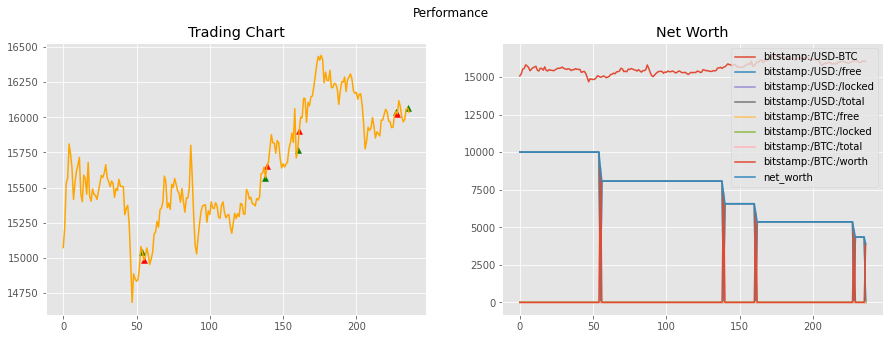

In [13]:
# Instantiate the environment
env = create_env(env_config_validation)

# Run until episode ends
done = False
obs = env.reset()
# Initialize hidden_state variable that will correspond to lstm_cell_size
hidden_state = [np.zeros(lstm_cell_size), np.zeros(lstm_cell_size)]

i = 0
while not done:
    # In order for use_lstm to work we set full_fetch to True
    # This changes the output of compute action to a tuple (action, hidden_state, info)
    # We also pass in the previous hidden state in order for the model to use correctly use the LSTM
    action, hidden_state, _ = agent.compute_action(obs, state=hidden_state, full_fetch=True)
    obs, reward, done, info = env.step(action)

env.render()